In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import urllib
from PIL import Image

In [4]:
PATH = 'data/tawkify/'
image_folder = f'{PATH}train/'
data_csv = PATH+'tw_dem_images.csv'
image_csv = PATH+'image_csv.csv'

model_csv = f'{PATH}current_model_gender.csv'

In [5]:
sz=224
# sz=400

### Create Training CSV data from Image CSV

In [6]:
img_df = pd.read_csv(image_csv)

In [7]:
img_df.shape

(89642, 10)

In [ ]:
plt.imshow(plt.imread(img_df.local_photo.iloc[np.random.randint(10)]))

In [ ]:
size_map = { idx:plt.imread(k.local_photo).shape for idx,k in img_df.iterrows()}

In [ ]:
size_map

In [ ]:
h, w, ch = list(zip(*size_map.values()))

In [ ]:
plt.hist(w)

In [ ]:
w = np.array(w)
plt.hist(w[w<600])

In [ ]:
img_df.head()

In [ ]:
img_df.loc[img_df.gender.isna()]

In [21]:
temp_df = img_df.loc[~img_df.gender.isna()]
temp_df = pd.DataFrame(data={'id': temp_df.userID, 'gender': temp_df.gender}, columns=['id', 'gender'])
temp_df.to_csv(model_csv, index=False)

In [24]:
temp_df.shape

(59092, 2)

### Sample 50-50

In [31]:
temp_df = img_df.loc[~img_df.gender.isna()]
temp_df = pd.DataFrame(data={'id': temp_df.userID, 'gender': temp_df.gender}, columns=['id', 'gender'])


temp_df = temp_df.loc[~((temp_df.gender == 'female') & (temp_df.id % 2 == 0))]
temp_df = temp_df.sample(n=10000)

temp_df.to_csv(model_csv, index=False)

### Architecture

In [35]:
# !rm -rf {PATH}tmp

In [8]:
temp_df = pd.read_csv(model_csv)

In [9]:
gender_count = temp_df.groupby('gender').count()
# print(gender_count)
print(gender_count/gender_count.sum())
print(temp_df.shape)

            id
gender        
female  0.5285
male    0.4715
(10000, 2)


In [10]:
arch=resnet34

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
n = temp_df.shape[0]-1
val_idxs = get_cv_idxs(n)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=model_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, bs=64)


In [26]:
new_data = data.resize(sz, f'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [14]:
m = arch(pretrained=True)

In [15]:
# m

In [16]:
# make sure to try batchnorm after first conv2d layer

In [17]:
m = nn.Sequential(*children(m)[:-2],
                      nn.Conv2d(512, 2, 3, padding=1),
                      nn.BatchNorm2d(2),
                      nn.AdaptiveAvgPool2d(1),
                      Flatten(),
                      nn.LogSoftmax())

In [18]:
def show_image(idx):
    x,y = data.trn_ds[idx]
    show_img = data.trn_ds.denorm(x)
    print(show_img.shape)
    print('Y value:', y)
    plt.imshow(show_img[0])

(1, 224, 224, 3)
Y value: 0


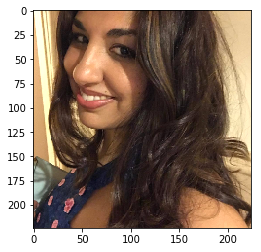

 12%|█▏        | 948/8001 [00:20<02:28, 47.35it/s] 

In [19]:
show_image(3)

In [28]:
# learn = ConvLearner.pretrained(arch, data=new_data, precompute=True)
# learn = ConvLearner.pretrained(arch, data=new_data)
learn = ConvLearner.from_model_data(m, data=new_data)

In [27]:
learn.model

NameError: name 'learn' is not defined

In [97]:
learn.freeze_to(-5)

In [102]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.382092   2.19239    0.646777  


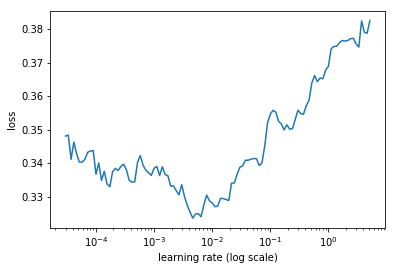

In [103]:
learn.sched.plot()

In [100]:
learn.fit(lrs=1e-2, n_cycle=2,)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.416329   0.355742   0.846289  
    1      0.364351   0.337731   0.852148                    


[0.33773136, 0.852148437872529]

In [101]:
learn.save('tw_gender_cam_firstrun1e-2')

In [ ]:
learn.load('tw_gender_cam_firstrun1e-2')

In [104]:
learn.precompute=False

In [105]:
learn.fit(lrs=1e-3, n_cycle=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.337455   0.34612    0.846159  
    1      0.331935   0.341527   0.846647                    


[0.34152663, 0.846647135913372]

In [106]:
learn.save('tw_gender_cam_run2')

In [86]:
learn.unfreeze()

In [87]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.638014   1356395008.0 0.466829  


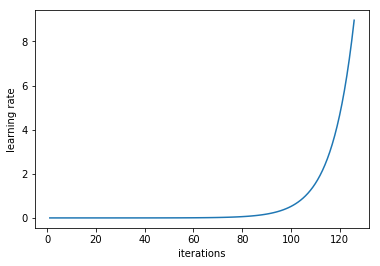

In [88]:
learn.sched.plot_lr()

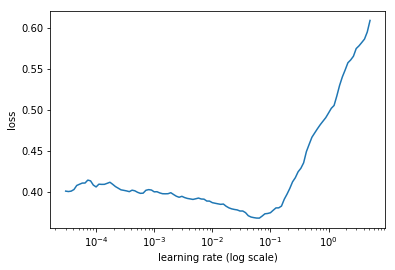

In [89]:
learn.sched.plot()

In [90]:
learn.fit(lrs=[1e-5,1e-4,1e-3], n_cycle=2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.405445   0.40357    0.823958  
    1      0.411113   0.396449   0.824935                    


[0.3964492, 0.824934896081686]

In [ ]:
learn.save('tw_gender_cam_unfreeze1')

In [ ]:
learn.load('tw_gender_cam_unfreeze1')

In [ ]:
learn.fit(lrs=[1e-5,1e-4,1e-3], n_cycle=3, cycle_mult=2)

In [ ]:
learn.save('tw_gender_cam_unfreeze2_nc3cm2')

In [24]:
learn.load('tw_gender_cam_unfreeze2_nc3cm2')

NameError: name 'learn' is not defined

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

In [ ]:
preds = np.argmax(log_preds, axis=1)
# np.array(preds==y).mean()
preds
# accuracy(log_preds,y)

### Test image

In [ ]:
test_image_url = 'https://images-na.ssl-images-amazon.com/images/M/MV5BMTk4MDM0MDUzM15BMl5BanBnXkFtZTcwOTI4MzU1Mw@@._V1_UY317_CR7,0,214,317_AL_.jpg'

In [ ]:
# test_image_file = f'{PATH}test_images/test1.jpg'
# test_image_file = f'{PATH}test_images/kenneth_s.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2776.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_8274.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_3135.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_8819.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9370.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2793.jpg'
# test_image_file = f'{PATH}test_images/grandma_test1.jpg'
test_image_file = f'{PATH}test_images/lzl_test1.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9625.jpg'

# test_image_file = f'{PATH}test_images/jackie_test1.jpg'

In [ ]:
# urllib.request.urlretrieve(test_image_url, test_image_file)

In [ ]:
plt.imshow(plt.imread(test_image_file))

In [ ]:
val_tfms = tfms[1]

In [ ]:
eval_mode = learn.model.eval()
# needed so that we know we are in evaluation mode. Otherwise will throw an exception
# equivalent to learn.model.train(False)

In [ ]:
# test_image = val_tfms(plt.imread(test_image_file))
test_image = val_tfms(open_image(test_image_file))
prediction = np.exp(learn.predict_array([test_image]))
class_prediction = data.classes[np.argmax(prediction)]
print('Prediction: ', class_prediction)

## CAM

In [39]:
class SaveFeatures():
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = to_np(output)
    def remove(self):
        self.hook.remove()

In [40]:
val_iter = iter(data.val_dl)

In [89]:
x,y = next(val_iter)
# x,y = next(iter(data.val_dl))
x,y = x[None,1], y[None,1]

vx = Variable(x.cuda(), requires_grad=True)

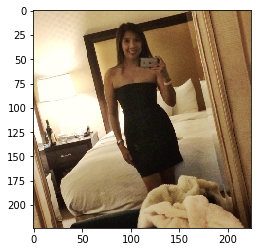

In [90]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx)

In [91]:
testl = m[-10]
print(testl)
testfeat = SaveFeatures(testl)
py = m(Variable(x.cuda()))
testfeat.features[0].shape

MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)


(64, 56, 56)

In [92]:
sf = SaveFeatures(m[-5])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([0.5, 0.5], dtype=float32)

In [93]:
print('Prediction:', data.classes[py.argmax()])
print('Actual:', data.classes[y[0]])

Prediction: female
Actual: female


In [94]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

In [95]:
f2 = np.dot(np.rollaxis(feat,0,3), py)
f2 -= f2.min()
f2 /= f2.max()
f2

array([[0.07013, 0.16751, 0.31746, 0.11609, 0.19394, 0.29776, 0.2196 ],
       [0.     , 0.21679, 0.21485, 0.0601 , 0.32578, 0.24805, 0.0982 ],
       [0.03723, 0.07865, 0.18218, 0.25282, 0.1586 , 0.08739, 0.07949],
       [0.27657, 0.30405, 0.4287 , 0.49715, 0.60487, 0.26709, 0.16192],
       [0.35442, 0.3414 , 0.77812, 0.76172, 0.84462, 0.51328, 0.2603 ],
       [0.04806, 0.4724 , 0.75583, 1.     , 0.83464, 0.52043, 0.33883],
       [0.10682, 0.21342, 0.19478, 0.38462, 0.40227, 0.44628, 0.51721]], dtype=float32)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


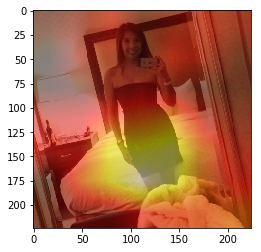

In [96]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot')